In [1]:
# Original coding process

import sqlite3
import pandas as pd

# Connecting to the database
conn = sqlite3.connect('C:\\Users\\Sarabjeet Kour\\Database (1).db')
data = pd.read_sql_query('SELECT * FROM New_Delhi_Reviews', conn)

print("Dataset successfully loaded...\n")
# Display the first few rows to inspect the data
print("Displaying first few rows of the dataset:\n")
print(data.head())

# Checking data types before conversion
print("\nData types before conversion:")
print(data.dtypes)

# Closing the connection
conn.close()

Dataset successfully loaded...

Displaying first few rows of the dataset:

  rating_review                                        review_full
0             5  Totally in love with the Auro of the place, re...
1             5  I went this bar 8 days regularly with my husba...
2             5  We were few friends and was a birthday celebra...
3             5  Fatjar Cafe and Market is the perfect place fo...
4             5  Hey Guys, if you are craving for pizza and sea...

Data types before conversion:
rating_review    object
review_full      object
dtype: object


In [2]:
import re
import nltk

# Downloading necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Removing URLs from the 'review_full' column
data['cleaned_review'] = data['review_full'].str.replace(r'http\S+', '', regex=True)

# Removing special characters and numbers from the 'cleaned_review' column
data['cleaned_review'] = data['cleaned_review'].str.replace(r'[^A-Za-z\s]', '', regex=True)

# Converting the 'cleaned_review' column to lowercase
data['cleaned_review'] = data['cleaned_review'].str.lower()

# Printing some cleaned reviews
print("Cleaned Review Examples:")
print(data['cleaned_review'].head())


[nltk_data] Downloading package punkt to C:\Users\Sarabjeet
[nltk_data]     Kour\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sarabjeet
[nltk_data]     Kour\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned Review Examples:
0    totally in love with the auro of the place rea...
1    i went this bar  days regularly with my husban...
2    we were few friends and was a birthday celebra...
3    fatjar cafe and market is the perfect place fo...
4    hey guys if you are craving for pizza and sear...
Name: cleaned_review, dtype: object


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=5)

# Fitting the vectorizer on the cleaned reviews and transform the data
X = vectorizer.fit_transform(data['cleaned_review'])

# Checking the shape of the resulting TF-IDF matrix 
print("TF-IDF matrix shape:", X.shape)

# Optionally, checking the feature names
print("\nFeature names (terms) extracted by TF-IDF:")

# Displaying the first 20 terms for inspection
print(vectorizer.get_feature_names_out()[:20])  


TF-IDF matrix shape: (147581, 24027)

Feature names (terms) extracted by TF-IDF:
['aa' 'aachar' 'aachari' 'aad' 'aadmi' 'aagya' 'aah' 'aahgya' 'aaj'
 'aakash' 'aalo' 'aalok' 'aaloo' 'aalu' 'aam' 'aamodini' 'aampanna'
 'aamras' 'aan' 'aanch']


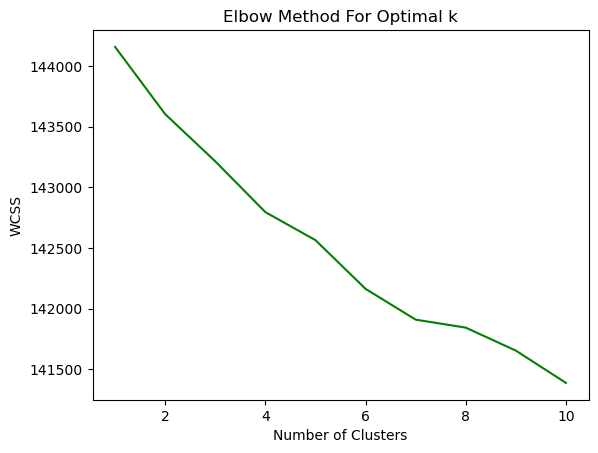

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Using elbow method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares (WCSS)
for k in range(1, 11):  # Trying values of k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # The WCSS is the inertia

# Plotting the Elbow curve
plt.plot(range(1, 11), wcss, color='g')  
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()



In [5]:
# Applying K-Means clustering (assuming 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

# Inspecting the cluster distribution
print("\nCluster Distribution:")
print(data['cluster'].value_counts())



Cluster Distribution:
cluster
2    84686
3    29482
1    26265
0     7148
Name: count, dtype: int64


In [6]:
import numpy as np

# Getting the feature names (terms) from the TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Function to get the top words in each cluster
def get_top_words(cluster_centers, terms, num_words=10):
    top_words = []
    for i in range(cluster_centers.shape[0]):
        top_indices = cluster_centers[i].argsort()[-num_words:][::-1]  # Getting indices of top words
        top_words.append([terms[index] for index in top_indices])
    return top_words

# Getting top words for each cluster
top_words = get_top_words(kmeans.cluster_centers_, terms)

# Displaying the top words for each cluster
for i, words in enumerate(top_words):
    print(f"\nTop words for cluster {i}:")
    print(", ".join(words))



Top words for cluster 0:
indian, south, food, place, good, north, dosa, restaurant, authentic, delhi

Top words for cluster 1:
good, food, place, nice, service, ambience, really, restaurant, staff, quality

Top words for cluster 2:
food, place, chicken, restaurant, good, best, delhi, taste, just, try

Top words for cluster 3:
great, food, service, excellent, staff, amazing, place, restaurant, experience, ambience


In [9]:
# Importing nltk library
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package movie_reviews to C:\Users\Sarabjeet
[nltk_data]     Kour\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sarabjeet
[nltk_data]     Kour\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sarabjeet
[nltk_data]     Kour\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from textblob import TextBlob

# Function to get sentiment polarity (positive if >0, negative if <0, neutral if 0)
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Applying sentiment analysis to each review
data['sentiment'] = data['review_full'].apply(get_sentiment)

# Assigning sentiment labels (positive, neutral, negative)
data['sentiment_label'] = data['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Grouping by cluster and calculating sentiment distribution
cluster_sentiment = data.groupby('cluster')['sentiment_label'].value_counts()
print("\nSentiment Distribution Across Clusters:")
print(cluster_sentiment)



Sentiment Distribution Across Clusters:
cluster  sentiment_label
0        positive            6873
         negative             208
         neutral               67
1        positive           25921
         negative             328
         neutral               16
2        positive           74939
         negative            8746
         neutral             1001
3        positive           29205
         negative             249
         neutral               28
Name: count, dtype: int64


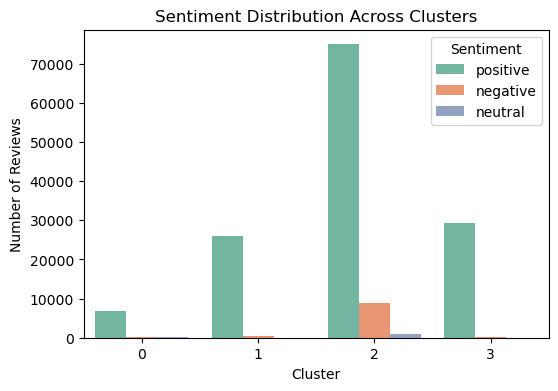

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting sentiment distribution by cluster
plt.figure(figsize=(6, 4))
sns.countplot(x='cluster', hue='sentiment_label', data=data, palette='Set2') 
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment', loc='upper right')
plt.show()

In [12]:
# Mapping clusters to their labels
cluster_labels = {
    0: "Mixed Experience with Room for Improvement",
    1: "Highly Positive Dining Experience",
    2: "Dish-Specific Reviews with Some Dissatisfaction",
    3: "Outstanding Experience with Excellent Service"
}

# Assigning labels to the clusters in the dataset
data['cluster_label'] = data['cluster'].map(cluster_labels)

# Showing the first 20 rows for review
print(data[['cluster', 'cluster_label']].head(20))


    cluster                                    cluster_label
0         2  Dish-Specific Reviews with Some Dissatisfaction
1         2  Dish-Specific Reviews with Some Dissatisfaction
2         1                Highly Positive Dining Experience
3         2  Dish-Specific Reviews with Some Dissatisfaction
4         2  Dish-Specific Reviews with Some Dissatisfaction
5         2  Dish-Specific Reviews with Some Dissatisfaction
6         2  Dish-Specific Reviews with Some Dissatisfaction
7         2  Dish-Specific Reviews with Some Dissatisfaction
8         2  Dish-Specific Reviews with Some Dissatisfaction
9         3    Outstanding Experience with Excellent Service
10        1                Highly Positive Dining Experience
11        2  Dish-Specific Reviews with Some Dissatisfaction
12        2  Dish-Specific Reviews with Some Dissatisfaction
13        2  Dish-Specific Reviews with Some Dissatisfaction
14        2  Dish-Specific Reviews with Some Dissatisfaction
15        3    Outstandi

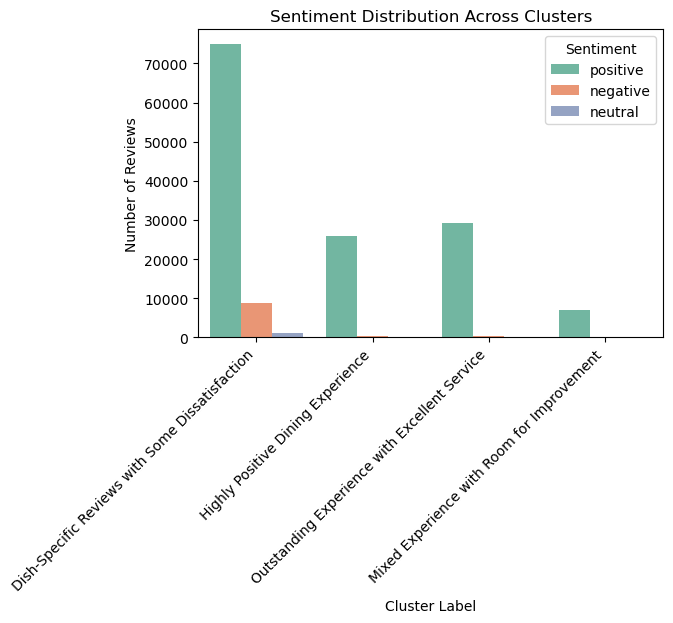

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting sentiment distribution across clusters
plt.figure(figsize=(6, 4))
sns.countplot(x='cluster_label', hue='sentiment_label', data=data, palette='Set2')  
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.show()


In [14]:
# We can do group by and then sample directly
sample_reviews = data.groupby('cluster_label').head(3)  

# Displaying the sampled reviews
print(sample_reviews[['cluster_label', 'review_full']])


                                       cluster_label  \
0    Dish-Specific Reviews with Some Dissatisfaction   
1    Dish-Specific Reviews with Some Dissatisfaction   
2                  Highly Positive Dining Experience   
3    Dish-Specific Reviews with Some Dissatisfaction   
9      Outstanding Experience with Excellent Service   
10                 Highly Positive Dining Experience   
15     Outstanding Experience with Excellent Service   
16     Outstanding Experience with Excellent Service   
19                 Highly Positive Dining Experience   
73        Mixed Experience with Room for Improvement   
291       Mixed Experience with Room for Improvement   
300       Mixed Experience with Room for Improvement   

                                           review_full  
0    Totally in love with the Auro of the place, re...  
1    I went this bar 8 days regularly with my husba...  
2    We were few friends and was a birthday celebra...  
3    Fatjar Cafe and Market is the perfect 

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Filtering positive and negative reviews from a specific cluster (e.g., Cluster 0)
cluster_0_reviews = data[data['cluster_label'] == 'Mixed Experience with Room for Improvement']

# Positive and negative reviews
positive_reviews = cluster_0_reviews[cluster_0_reviews['sentiment_label'] == 'positive']['review_full']
negative_reviews = cluster_0_reviews[cluster_0_reviews['sentiment_label'] == 'negative']['review_full']

# Initializing CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)  # Top 10 words

# Fitting on positive reviews
positive_words = vectorizer.fit_transform(positive_reviews)
positive_word_freq = pd.DataFrame(positive_words.toarray(), columns=vectorizer.get_feature_names_out())

# Fitting on negative reviews
negative_words = vectorizer.fit_transform(negative_reviews)
negative_word_freq = pd.DataFrame(negative_words.toarray(), columns=vectorizer.get_feature_names_out())

# Displaying top words for positive and negative reviews
print("Top Words in Positive Reviews (Cluster 0):")
print(positive_word_freq.sum().sort_values(ascending=False).head())

print("\nTop Words in Negative Reviews (Cluster 0):")
print(negative_word_freq.sum().sort_values(ascending=False).head())


Top Words in Positive Reviews (Cluster 0):
indian    10372
food       8971
south      7757
place      4186
good       4066
dtype: int64

Top Words in Negative Reviews (Cluster 0):
indian        293
food          266
south         225
restaurant     99
place          95
dtype: int64


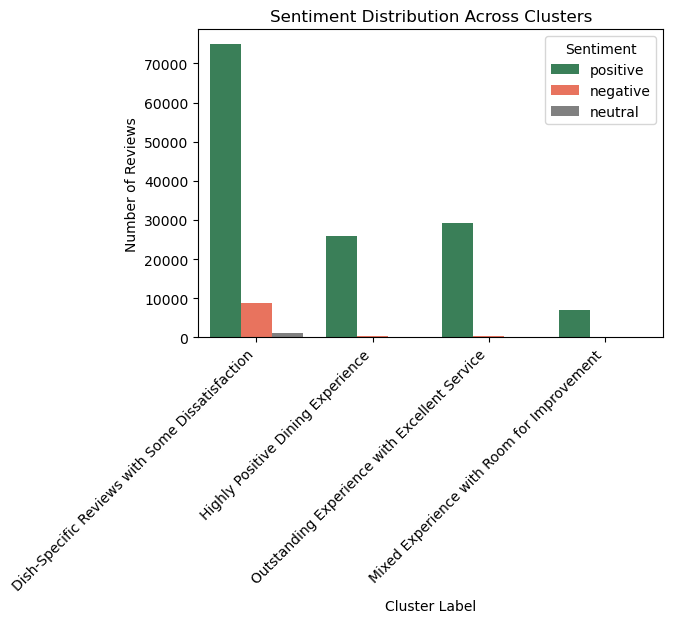

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Defining custom colors for positive, negative, and neutral sentiments
custom_palette = ['#2E8B57', '#FF6347', '#808080']  # Green for positive, Red for negative, Gray for neutral

# Plotting sentiment distribution across clusters with custom colors
plt.figure(figsize=(6, 4))
sns.countplot(x='cluster_label', hue='sentiment_label', data=data, palette=custom_palette)
plt.title('Sentiment Distribution Across Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.show()


### **Analyzing Customer Sentiments and Clustering Reviews from TripAdvisor**

This analysis aims to cluster **customer reviews** from **TripAdvisor** into meaningful themes based on the text content. By performing this clustering, we can identify customer sentiments (both positive and negative) and help businesses improve their services, tailor their offerings, and enhance customer experiences.

#### **Problem Statement:**
The goal is to:
- Automatically **cluster** customer reviews into different themes (such as food quality, service, ambiance, etc.).
- Perform **sentiment analysis** to understand customer sentiments—positive, negative, or neutral.
- Provide businesses with insights that can inform strategies to enhance customer satisfaction and improve their services.

---

### **Solution Approach**

The solution consists of the following key steps:

---

### **1. Text Data Cleaning**
The first step in analyzing customer reviews is to clean the raw text data to remove any noise and make it easier to process.

#### **Steps Involved:**
- **Remove URLs and special characters**: Cleaning unnecessary text.
- **Convert text to lowercase**: Ensures uniformity across reviews.
- **Tokenize reviews**: Splitting the text into words.
- **Remove stop words**: Common but non-informative words (e.g., "the", "and", "is").

---

### **2. Feature Extraction from Text Data**
Once the reviews are cleaned, they need to be transformed into a format that can be used by clustering algorithms. This is done using **TF-IDF** vectorization, which converts the text into numerical data.

#### **TF-IDF Vectorization:**
- **Stop words removal**: Using built-in stop word lists.
- **Matrix representation**: The resulting matrix represents each review as a vector of numerical values. These values indicate the importance of words in each review relative to the entire dataset.

---

### **3. Clustering of Reviews**
After the reviews are represented numerically, we apply **K-Means clustering**, an unsupervised machine learning algorithm that groups data into clusters based on similarity.

#### **Determining the Optimal Number of Clusters:**
- The **Elbow Method** is used to determine the optimal number of clusters. By plotting the **Within-Cluster Sum of Squares (WCSS)** for different values of **k**, we can observe the "elbow" point where increasing the number of clusters no longer significantly reduces the WCSS.

- Based on this analysis, we choose **4 clusters** for this dataset.

---

### **4. Assigning Meaningful Labels to Clusters**
After clustering, we analyze the most frequent words in each cluster to determine the common themes that define each group of reviews.

#### **Cluster Labels:**
- **Cluster 0: "Mixed Experience with Room for Improvement"**
- **Cluster 1: "Highly Positive Dining Experience"**
- **Cluster 2: "Dish-Specific Reviews with Some Dissatisfaction"**
- **Cluster 3: "Outstanding Experience with Excellent Service"**

Each label represents a summary of the reviews in that cluster based on the words most frequently mentioned by customers.

---

### **5. Sentiment Analysis**
We perform sentiment analysis to categorize each review as **positive**, **negative**, or **neutral** based on its sentiment score. The **TextBlob** library is used to compute the sentiment **polarity score** of each review:

- **Positive sentiment**: Reviews with a polarity score > 0.
- **Negative sentiment**: Reviews with a polarity score < 0.
- **Neutral sentiment**: Reviews with a polarity score = 0.

The sentiment distribution across clusters is then analyzed to understand how sentiment varies between different themes.

---

### **6. Visualizations**
Several visualizations help to communicate the findings clearly:

- **Sentiment Distribution by Cluster**: A bar plot is generated to show the breakdown of **positive, negative**, and **neutral** reviews across the different clusters.
- **Top Words in Positive and Negative Reviews**: For each cluster, the most frequent words in **positive** and **negative** reviews are displayed. This highlights key aspects like **service quality**, **food taste**, etc.
- **Custom Color Palette for Sentiment Visualization**: A color palette (green for positive, red for negative, gray for neutral) is used for clarity in sentiment visualizations.

---

### **Key Insights from the Analysis**

1. **Cluster 0: "Mixed Experience with Room for Improvement"**
   - **Top Words**: "food", "place", "restaurant", "service", "staff".
   - **Sentiment**: Mostly positive reviews but with many **negative** sentiments, especially around **service** and **staff**. Customers like the food and place but see room for improvement in service quality.
   
2. **Cluster 1: "Highly Positive Dining Experience"**
   - **Top Words**: "good", "food", "service", "place", "restaurant".
   - **Sentiment**: Largely **positive sentiment**. Customers are happy with the food, service, and overall ambiance.

3. **Cluster 2: "Dish-Specific Reviews with Some Dissatisfaction"**
   - **Top Words**: "chicken", "butter", "food", "place", "tikka".
   - **Sentiment**: Reviews are mostly positive but with some **negative comments** specific to certain dishes (e.g., **chicken** or **butter chicken**).

4. **Cluster 3: "Outstanding Experience with Excellent Service"**
   - **Top Words**: "great", "food", "service", "ambience", "staff".
   - **Sentiment**: **Predominantly positive** reviews highlighting excellent food, service, and ambiance.

---

### **Top Positive and Negative Themes Identified**

- **Positive Themes**:
   - "Good food"
   - "Great service"
   - "Pleasant ambiance"
   - "Friendly staff"
   - "Authentic Indian cuisine"

- **Negative Themes**:
   - "Slow service"
   - "Poor customer support"
   - "Staff issues"
   - "Bad experience with specific dishes"

These themes can help businesses focus on areas that are both liked and disliked by customers, enabling them to fine-tune their offerings.

---

### **Future Application for New Reviews**

The clustering model can be applied to automatically categorize **new reviews** as they come in. The key benefits are:
- **Automatic Categorization**: New reviews can be automatically assigned to one of the existing clusters, saving time and effort in manual analysis.
- **Real-Time Insights**: This enables businesses to gain real-time insights into customer sentiment and emerging issues, which can be addressed proactively.

By updating the model with new reviews over time, the system will continue to improve, making it more accurate in identifying themes and sentiments in future customer feedback.

---

### **Conclusion**

This analysis successfully clusters **TripAdvisor reviews** into meaningful themes, providing businesses with valuable insights into customer sentiments. By identifying **positive and negative themes**, businesses can make data-driven decisions to improve services, address issues, and enhance customer experiences.

Additionally, the clustering model can be used for **automatic categorization** of future reviews, enabling businesses to scale and efficiently manage large volumes of feedback.
